### Filling Factor
- **ν**: Filling factor 1/2
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Key Physics
- **Ground state competition**: in n=0 Landau level, competition between pfaffin-related states and composite Fermi liquids; in n=1 Landau level, Moore-Read states are the ground states.

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ))
# use exact values, Integer or Rational, to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, ss_k1, ss_k2; 
    title = nothing, ylims = (nothing, nothing),
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)",
)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = ylabel
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_k1)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
    fig
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x-0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
    fig
end

plot_entanglement_spectrum (generic function with 1 method)

In [2]:
# Define 4×4 k-mesh (Nk=16) 

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]

# System parameters
Nk = 16         # Total number of k-points
Gk = (4, 4)     # Grid dimensions (G1_direction, G2_direction)

Ne = 8          # Ne=8 -> ν=1/2; Ne=4 -> ν=1/4;

=#

In [3]:
# Define 3×6 k-mesh (Nk=18) 

k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 9          # Ne=9 -> ν=1/2; Ne=6 -> ν=1/3;


9

In [4]:
# Define 4×5 k-mesh (Nk=20) 

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]

# System parameters
Nk = 20         # Total number of k-points
Gk = (4, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # Ne=10 -> ν=1/2; Ne=4 -> ν=1/5;

=#

In [5]:
# Define 4×6 k-mesh (Nk=24) 

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6]

# System parameters
Nk = 24         # Total number of k-points
Gk = (4, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 12         # 12 -> ν=1/2; 8 -> ν=1/3; 6 -> ν=1/4; 4 -> ν=1/6;

=#

In [6]:
# Generating H_m: the m-pseudopotential operator
m_list = 0:20
Hm = Vector{MBOperator}(undef, length(m_list))
for i in eachindex(m_list)
    m = m_list[i]
    local sys_int = LandauInteraction(
        tri_lattice, (1,0,1,0) # consistent to the computed system
    );
    sys_int.V_intra = [fill(0.0, m); 1.0]
    sys_int.mix = 1.0

    local para = EDPara(k_list = k_list, Gk = Gk, V_int = sys_int)
    local scat = ED_sortedScatterList_twobody(para);
    Hm[i] =  MBOperator(scat; upper_hermitian = true)
end

In [7]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(tri_lattice, (1, 0, 1, 0));

# use Haldane pseudopotential
sys_int.V_intra = [0.0; 1.0; 0.0; 0.0]

# show the pseudopotential decomposition of the gate-screened Coulomb interaction for reference
sys_int.D_l = 10.0                              # gate distance / magnetic length 
Coulomb_PP = LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0);
@show Coulomb_PP
# sys_int.V_intra = Coulomb_PP

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = k_list, Gk = Gk, 
    V_int = sys_int, FF_inf_angle = LLT.Landau_ff_inf(sys_int));

Coulomb_PP = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637]


In [8]:
# Create momentum blocks (Hilbert subspace)
subspaces, ss_k1, ss_k2 = ED_momentum_subspaces(para, (Ne, ));
display(length.(subspaces))

# one-body terms are all zero in flat Landau level
scat = ED_sortedScatterList_twobody(para);

# construct the Hamiltonian operator
hmlt = MBOperator(scat; upper_hermitian = true)

18-element Vector{Int64}:
 2710
 2700
 2700
 2710
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700
 2700

Many Body Operator (Hermitian, upper triangle entries only) :
	Vector{EDCore.Scatter{ComplexF64, MBS64{18}}} with 729 scattering terms


In [9]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], hmlt;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 2710, momentum 0, 0
  0.508873 seconds (12.95 M allocations: 453.406 MiB, 10.14% gc time, 380.37% compilation time)
  0.958821 seconds (3.03 M allocations: 173.731 MiB, 138.77% compilation time)
Processing subspace #2 with size 2700, momentum 0, 1
  0.070157 seconds (11.17 M allocations: 362.669 MiB, 51.62% gc time)
  0.088675 seconds (6.78 k allocations: 29.963 MiB, 5.14% gc time)
Processing subspace #3 with size 2700, momentum 0, 2
  0.193619 seconds (11.17 M allocations: 363.938 MiB, 72.22% gc time)
  0.089880 seconds (6.59 k allocations: 28.706 MiB, 2.13% gc time)
Processing subspace #4 with size 2710, momentum 0, 3
  0.043601 seconds (11.22 M allocations: 369.281 MiB, 35.20% gc time)
  0.079096 seconds (6.16 k allocations: 25.212 MiB, 5.31% gc time)
Processing subspace #5 with size 2700, momentum 0, 4
  0.046666 seconds (11.17 M allocations: 362.659 MiB, 38.28% gc time)
  0.086474 seconds (6.78 k allocations: 29.964 MiB, 3.55% gc time)
Processing s

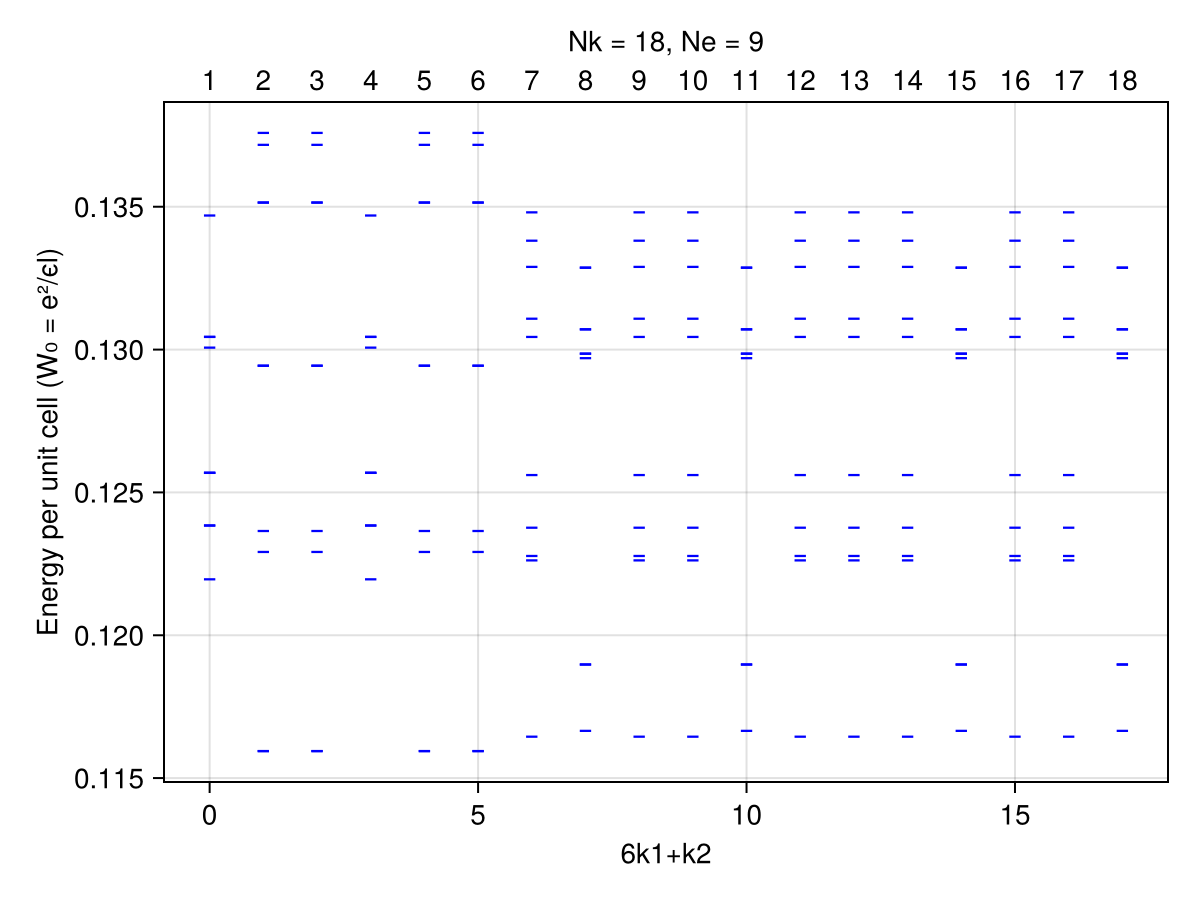

In [10]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2,
    title = "Nk = $Nk, Ne = $Ne",
    # ylims = (0.115, 0.120),
);

In [11]:
# check energies explicitly to see degeneracy.

sn = 7 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 1  0


10-element Vector{Float64}:
 0.1164481978037413
 0.12261996751926141
 0.1227746836707534
 0.12376396179462278
 0.12560732817496276
 0.1304422858965192
 0.13108055576878255
 0.13289468465557677
 0.13381142955237968
 0.13480371359227003

Compute and plot one-body reduced density matrix

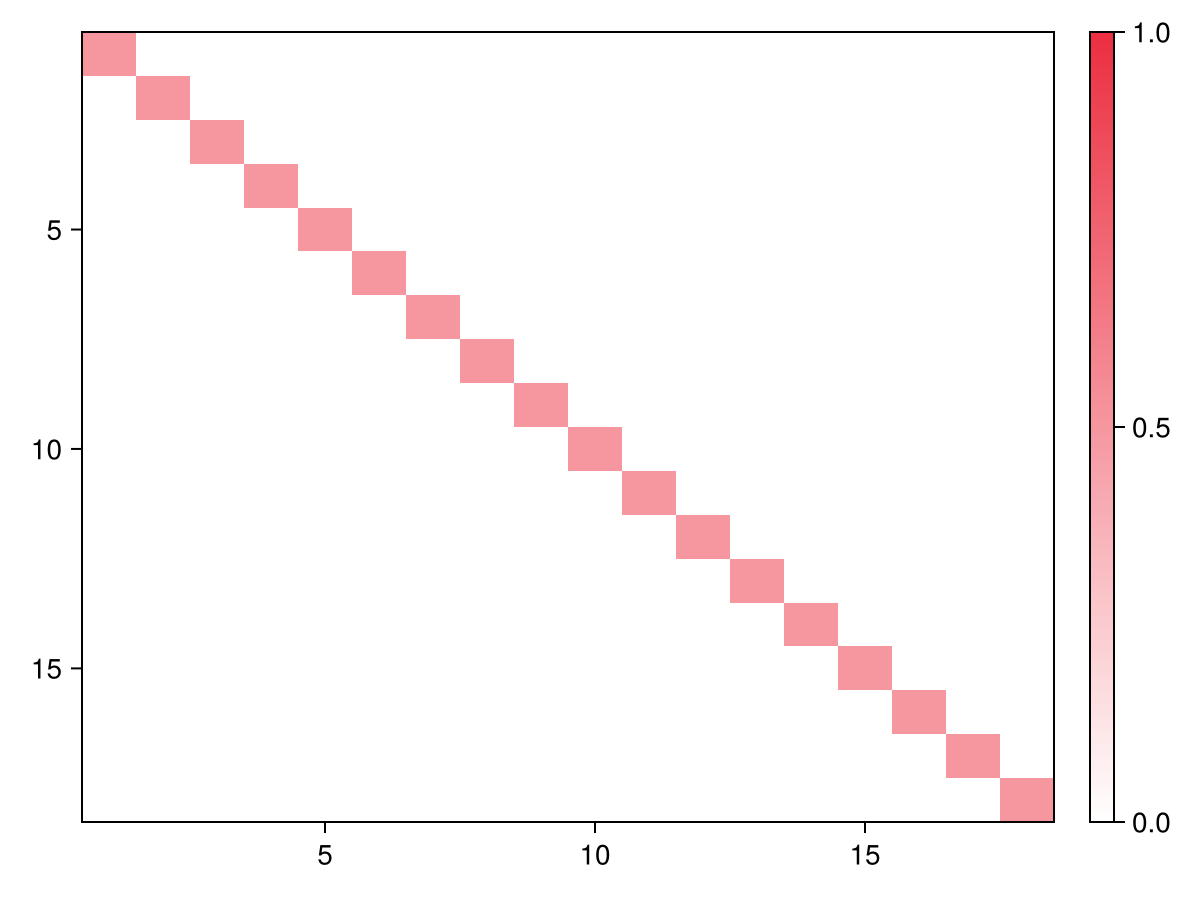

In [12]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
sn = 7
rdm1 = PES_1rdm(vectors[sn][1])
# rdm1 = sum(i->PES_1rdm(vectors[sn][i]), 1:2)

fig, ax, hm = heatmap(abs.(rdm1); colorrange = (0,1), axis = (;yreversed = true),
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm); fig

# scatterlines(diag(rdm1) .|> abs)

Compute the expectation values of pseudo-potentials of angular momemta m

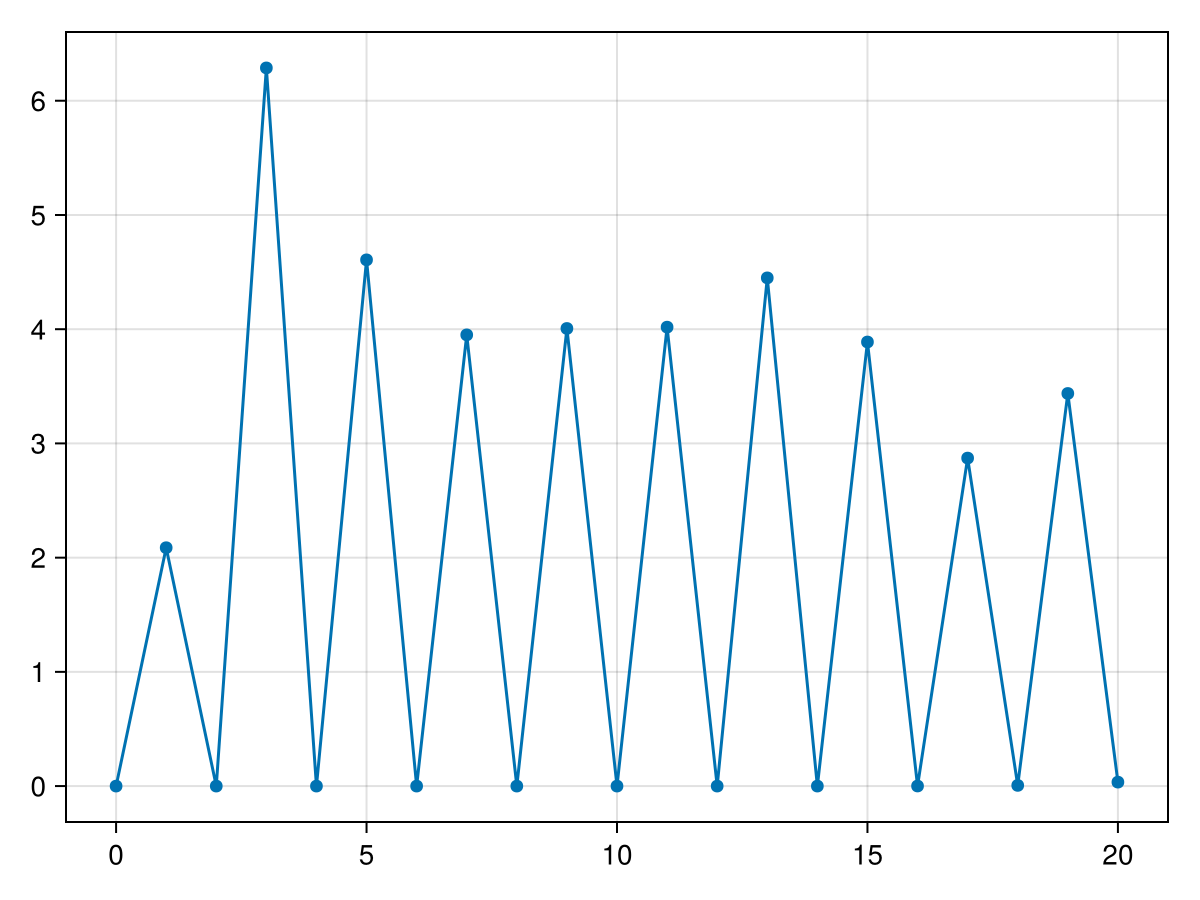

In [13]:
sn = 3
myvec = vectors[sn][1]
E_m = [ED_bracket(myvec, Hm[i], myvec) |> real for i in eachindex(m_list)]

display(scatterlines(m_list, E_m));

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [14]:
# path for the Wilson loop integral on base manifold
# Landau level has uniform Berry curvature, so we compute Berry curvature of a small plaquate and then multiply plaquate number
N_shift = 10  # number of shifts along each edge
path = Tuple{Rational, Rational}[(0//1, 0//1)]
push!(path, (1//N_shift, 0//1))
push!(path, (1//N_shift, 1//N_shift))
push!(path, (0//1, 1//N_shift))
push!(path, (0//1, 0//1))
path

5-element Vector{Tuple{Rational, Rational}}:
 (0, 0)
 (1//10, 0)
 (1//10, 1//10)
 (0, 1//10)
 (0, 0)

In [15]:
sn = 8                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before)  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatterList_twobody(para; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, float.(path[i+1]), float.(path[i]), para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (1//10, 0//1)
Inner product: amp = 1.000000000000003, phase = -0.22689280275923335
path point #2 	 (1//10, 1//10)
Inner product: amp = 1.0000000000000073, phase = 0.13788101090751706
path point #3 	 (0//1, 1//10)
Inner product: amp = 1.000000000000001, phase = 0.24260076602722275
path point #4 	 (0//1, 0//1)
Inner product: amp = 0.9999999999999953, phase = -0.12217304763960948


0.49999999999998485